<a href="https://colab.research.google.com/github/rainforest01-coder/ESAA_files/blob/main/ESAA_WEEK8_%EC%88%98%EC%83%81%EC%9E%91%EB%A6%AC%EB%B7%B0_%EC%A0%84%EB%A0%A5%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주제 및 데이터

##주제: 2025 전력 사용량 예측 AI경진대회

##데이터
Dataset Info.

❶10개 유형* 100개 건물의 전력소비량 데이터(1시간주기, ‘24.6.1～8.31),  
 ❷기상데이터**,  
 ❸건물개요(면적, 태양광·ESS 용량 등)

* 공공, 학교, 백화점, 병원, 아파트, 호텔 등

** 기온, 강수량, 풍속, 습도, 일조, 일사



1. train.csv

85일 분량의 데이터
train 데이터 : 100개 건물들의 2024년 06월 01일부터 2024년 08월 24일까지의 데이터
일시별 기온, 강수량, 풍속, 습도, 일조, 일사 정보 포함
전력사용량(kWh) 포함


2. building_info.csv

100개 건물 정보
건물 번호, 건물 유형, 연면적, 냉방 면적, 태양광 용량, ESS 저장 용량, PCS 용량


3. test.csv

test 데이터 : 100개 건물들의 2024년 08월 25일부터 2024년 08월 31일까지의 데이터
일시별 기온, 강수량, 풍속, 습도의 예보 정보


4. sample_submission.csv

제출을 위한 양식
100개 건물들의 2024년 08월 25일부터 2024년 08월 31일까지의 전력사용량(kWh)을 예측
num_date_time은 건물번호와 시간으로 구성된 ID
해당 ID에 맞춰 전력사용량 예측값을 answer 컬럼에 기입해야 함

---

#코드 리뷰

1. EDA
* 빌딩 타입 분포, 면적에 따른 에너지 소비량 scatter, 휴일이 존재하는 경우와 존재하지 않는 경우 시간에 따른 에너지 소비

2. 전처리
* 전력소비==0인 행 제거
* outlier파일에 명시된 특정 건물 및 날짜의 휴일 데이터 제거
* 시간 관련 변수 생성
  * 기본 변수: date_time에서 hour,day,month,day_of_week 추출
  * 주기성 변수: 시간의 연속성을 모델에 효과적으로 학습시키기 위해 삼각함수 변환 적용
  > sin_hour, cos_hour(하루 주기), sin_dayofweek, cos_dayofweek(일주일 주기), sin_month, cos_month(일년주기)
* 공휴일 변수 추가: 주말 또는 공휴일을 holiday=1로 처리
* 기상 복합 파생 변수:
  * CDH(cooling degree hour): 실외 기온이 어떤 기준 온도보다 얼마나 높았는지, 그리고 그 상태가 몇 시간 지속됐는지를 나타내는 지표(시간단위)
  * THI(temperature humidity index): 온도와 습도를 조합한 불쾌지수
  * WCT(Wind CHill Temperature): 온도와 풍속을 조합한 체감온도
* 통계기반 전력 변수: 과거 데이터 패턴 주입
  * day_hour_mean/std: 건물별 요일별 시간별 평균 및 표준편차 전력량
  * hour_mean/std: 건물별 시간별 평균 표준편차 전력량

* 여름 특화 변수: summer_cos, summer_sin 변수 만들어 추가한 모델, 추가하지 않은 모델 모두 앙상블에 사용

3. 모델링
* 주력 모델: XGBoostRegressor
  * gradient boosting 알고리즘으로 높은 예측 성능과 유연성을 제공하며 대용량 데이터 처리에 효율적
  * 데이터 특성상 numerical column이 많음
  * 하이퍼 파라미터: learning_rate:0.05,n_estimators:5000(early stopping 적용),max_depth: 건물 유형별 특성을 고려하여 6-10으로 차등 적용
  objective: weighted_mse(3) 실제값보다 예측값이 작을 때 더 큰 페널티를 주는 custom loss function
* Ensemble
  * 전체모델: 전체 데이터를 하나의 모델로 학습하여 일반적인 패턴 학습
  * 건물 유형별 모델: 10개 건물 유형으로 데이터를 분리하여 유형별 공동 패턴 학습
  * 건물별 모델: 100개 건물에 대해 각각 모델을 생성하여 건물 고유의 미세한 특성 학습
  * 클러스터 기반 모델: kmeans을 이용해 전력소비패턴이 유사한 건물들을 5개 그룹으로 군집화 한 후 그룹별 모델링

  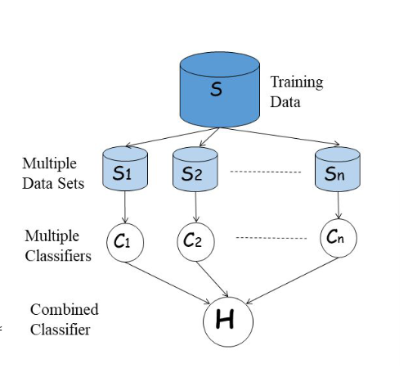

---
# 차별점 및 배울점
* 특징 공학(feature engineering)을 바탕으로 시간 기상 전력 소비 패턴 등 다양한 파생 변수 생성
* multi-modeling: 데이터 특성에 따라 전체, 건물 유형별, 건물별, 클러스터별 모델링 시도
* ensemble: 다양한 모델과 여러 seed값의 결과를 앙상블하여 최종 예측 성능 극대화
* post-processing: 특정 휴가 기간의 예외적 전력 패턴을 보정하기 위한 후처리 적용


https://dacon.io/competitions/official/236531/codeshare/12766?page=1&dtype=recent